In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensornetwork as tn
tn.set_default_backend("jax")
import jax.numpy as jnp
import jax
from jax import grad, jit, vmap, random

import copy
from jax.scipy.special import logsumexp
import math

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
def pooling(data):
    xlen = np.int(data.shape[1]/2)
    ylen = np.int(data.shape[2]/2)
    arr = np.zeros((data.shape[0], xlen, ylen))
    for i in range(0, data.shape[1], 2):
        for j in range(0, data.shape[2], 2):
            for k in range(0, data.shape[0]):
                arr[k][np.int(i/2)][np.int(j/2)] = \
                (data[k][i][j]+data[k][i+1][j]+data[k][i][j+1]+data[k][i+1][j+1])/4
    return arr

In [5]:
x_train_pool = pooling(x_train)
x_test_pool = pooling(x_test)

In [6]:
num_labels = 10

x_train = jnp.array(x_train_pool, dtype=jnp.float64)
x_test = jnp.array(x_test_pool, dtype=jnp.float64)

num_pixels = x_train.shape[1] * x_train.shape[2]
x_train_1d = jnp.reshape(x_train, (x_train.shape[0], num_pixels))
x_test_1d = jnp.reshape(x_test, (x_test.shape[0], num_pixels))

/home/ryunagai/virtualenvs/jax_cpu/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
def one_hot(x, k, dtype=jnp.float64):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

y_train_1h = one_hot(y_train, num_labels)
y_test_1h = one_hot(y_test, num_labels)

### Functions for Tensor Network

In [8]:
def feature_map(p):
    phi = jnp.array([1-p, p])
    return phi

def data_tensorize(vec):
    data_tensor = [tn.Node(feature_map(p)) for p in vec]
    return data_tensor

In [9]:
def block(*dimensions):
    '''Construct a new matrix for the MPS with random numbers from 0 to 1'''
    seed = np.random.randint(100)
    key = random.PRNGKey(seed)
    size = tuple([x for x in dimensions])
    scale = 0.35
    return scale * random.normal(key, size, dtype=jnp.float64)

def create_blocks(rank, dim, bond_dim, label_dim):
    half = jnp.array([(rank - 2) / 2], dtype = jnp.int32)[0]
    blocks = [
        block(dim, bond_dim) ] + \
        [ block(bond_dim, dim, bond_dim) for _ in range(half)] + \
        [ block(bond_dim, label_dim, bond_dim) ] + \
        [ block(bond_dim, dim, bond_dim) for _ in range(half, rank-2)] + \
        [ block(bond_dim, dim) 
        ]
    return blocks

def create_MPS_labeled(blocks, rank, dim, bond_dim):
    '''Build the MPS tensor'''
    #half = jnp.array([(rank - 2) / 2], dtype = jnp.int32)[0]
    mps = []
    for b in blocks:
        mps.append(tn.Node(b))

    #connect edges to build mps
    connected_edges=[]
    conn=mps[0][1]^mps[1][0]
    connected_edges.append(conn)
    for k in range(1,rank):
        conn=mps[k][2]^mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges

### Prediction function

In [10]:
label_len = 1
label_dim = 10
data_len = x_train_1d.shape[1]
rank = data_len
dim = 2
bond_dim = 10

blocks = create_blocks(rank, dim, bond_dim, label_dim)

@jit
def predict_2(data, blocks):
    data = [jnp.array([[1-p], [p]]) for p in data]
    half = math.floor(len(data)/2)
    mps = []
    dims = []
    mps += [data[0], blocks[0], blocks[1]]
    dims += [(1, -1), (1, 2), (2, 3, 4)]
    closed = 3
    opened = -2
    for i in range(1, half):
        mps += [data[i], blocks[i+1]]
        if i==half-1:
            dims += [(closed, opened), (closed+1, opened-1, closed+3)]
            opened -= 1
        else:
            dims += [(closed, opened), (closed+1, closed+2, closed+3)]
        closed += 2
        opened -= 1
    for j in range(half, len(data)-1):
        mps += [blocks[j+1], data[j]]
        dims += [(closed+1, closed+2, closed+3), (closed+2, opened)]
        closed += 2
        opened -= 1
    mps += [blocks[len(data)], data[-1]]
    dims += [(closed+1, closed+2), (closed+2, opened)]
    res = tn.ncon(mps, dims)
    res = jnp.squeeze(res)
    res = res - logsumexp(res)
    return res

def data_list(vec):
    data_list = [jnp.array([[1-p], [p]]) for p in vec]
    return data_list

In [11]:
@jit
def batched_predict_2(batch_data, blocks):
    return vmap(predict_2, in_axes=(0, None))(batch_data, blocks)

### Validation function

In [12]:
def accuracy(blocks, data, targets, params):
    batched_preds = batched_predict_2(data, blocks)
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(batched_preds, axis=1)
    return jnp.mean(predicted_class == target_class)

def loss(blocks, data, targets, params):
    batched_preds = batched_predict_2(data, blocks)
    return -jnp.mean(vmap(jnp.dot, in_axes=(0, 0))(batched_preds, targets))

### Train

In [13]:
@jit
def update(blocks, data, targets, params, lr = 1e-3):
    grads = grad(loss)(blocks, data, targets, params)
    return [x - lr * dx for x, dx in zip(blocks, grads)]

In [35]:
blocks = create_blocks(rank, dim, bond_dim, label_dim)
a = update(blocks, x_train_1d, y_train_1h, params)
l = loss(blocks, x_train_1d, y_train_1h, params)
l

DeviceArray(44.78271585, dtype=float64)

In [14]:
class batch_gen(object):
    def __init__(self, train, target, batch_size):
        self._train = train
        self._target = target
        self._batch_size = batch_size
        self._i = 0
    def __iter__(self):
        # __next__()はselfが実装してるのでそのままselfを返す
        return self
    def __next__(self):  # Python2だと next(self) で定義
        if self._i >= len(self._train):
            raise StopIteration()
        train_batch = self._train[self._i:self._i + self._batch_size]
        target_batch = self._target[self._i:self._i + self._batch_size]
        self._i += self._batch_size
        return (train_batch, target_batch)

In [ ]:
import time

batch_size = 30
num_epochs = 300
blocks = create_blocks(rank, dim, bond_dim, label_dim)
train_hist = []
loss_hist = []
params = (rank, dim, bond_dim, label_len, data_len)

for epoch in range(num_epochs):
    start_time = time.time()
    batch_num = 1
    batches = batch_gen(x_train_1d, y_train_1h, batch_size)
    for x, y in batches:
        blocks = update(blocks, x, y, params, 1e-3)
        #print('epoch: {}, batch: {}/{:0.0f}'.format(epoch, batch_num, len(x_train_1d)/batch_size))
        batch_num += 1

    train_acc = accuracy(blocks, x_train_1d, y_train_1h, params)
    train_hist.append(train_acc)
    loss_val = loss(blocks, x_train_1d, y_train_1h, params)
    loss_hist.append(loss_val)
    epoch_time = time.time() - start_time
    #test_acc = accuracy(blocks, x, y, params)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))
    print("Training set loss {}".format(loss_val))
    #print("Test set accuracy {}".format(test_acc))

Epoch 0 in 20.93 sec
Training set accuracy 0.09915
Training set loss nan
Epoch 1 in 20.68 sec
Training set accuracy 0.09915
Training set loss nan
Epoch 2 in 20.96 sec


In [112]:
test_loss = loss(blocks, x_test_1d, y_test_1h, params)
test_acc = accuracy(blocks, x_test_1d, y_test_1h, params)

In [113]:
print('train loss:{:.3f}'.format(loss_val))
print('train accuracy:{:.3f}'.format(train_acc))
print('test loss:{:.3f}'.format(test_loss))
print('test accuracy:{:.3f}'.format(test_acc))

train loss:0.118
train accuracy:0.962
test loss:0.216
test accuracy:0.952


### Learning curve

(0.0, 1.1)

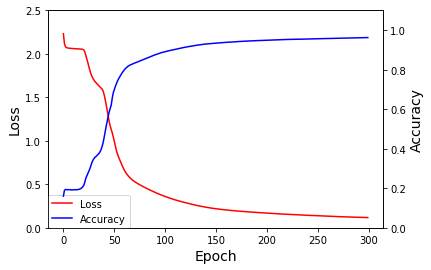

In [111]:
# lr 2e-5 -> 2e-4

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(loss_hist,
         color='r', label="Loss")
ax2.plot(train_hist, color='b',
        label="Accuracy")
 
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=3, borderaxespad=0.)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
 
ax1.set_ylim([0, 2.5])
ax2.set_ylim([0, 1.1])